In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

A significant obstacle in analyzing the LIDC dataset is the absence of unique identifiers for the nodules. Multiple radiologists may annotate the same nodule, but there are no clear markers indicating when different annotations refer to the same physical nodule, complicating the determination of whether they describe the same nodule. 

Using clustering, as mentioned previously, can lead to issues such as having nodule annotations that exceed 4 separate entries, which is impossible and indicates that the clustering function is not working correctly. Clustering based on coordinates introduces arbitrary decisions, such as setting thresholds for overlap, which can lead to errors and inaccuracies. 

By treating each annotation as an independent sample, we can capture the variability in feature quantification and malignancy ratings due to differences in radiologists' experience, training, and potential mislabeling. This approach enhances objectivity in the analysis by avoiding subjective clustering decisions. 

Furthermore, it simplifies modeling and reflects the natural variability in radiologists' interpretations, ultimately improving model robustness and eliminating the need to choose between mean, mode, or median for certain features.

In [4]:
df = pd.read_csv('radiomic_features_pylidc_and_fourier_per_annotation.csv')

# Identify non-numerical columns excluding 'Patient_ID' and 'Nodule_ID'
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
non_numeric_cols = [col for col in non_numeric_cols if col not in ['Patient_ID', 'Nodule_ID']]

# Drop the identified non-numerical columns
df = df.drop(columns=non_numeric_cols)

# Remove rows where 'malignancy' == 3
df = df[df['malignancy'] != 3]

# List of pylidc features to move to the end (before 'malignancy')
pylidc_features = [
    'subtlety',
    'internalStructure',
    'calcification',
    'sphericity',
    'margin',
    'lobulation',
    'spiculation',
    'texture',
    'diameter',
    'surface_area',
    'volume'
]

# Ensure 'Patient_ID' and 'Nodule_ID' are the first columns
# Move semantic features to the end (before 'malignancy'), and 'malignancy' column to the last position

# Get list of all columns
cols = df.columns.tolist()

# Remove 'Patient_ID', 'Nodule_ID', 'malignancy', and semantic features from the list
cols_to_exclude = ['Patient_ID', 'Nodule_ID', 'malignancy'] + pylidc_features
cols = [col for col in cols if col not in cols_to_exclude]

# Build the new columns order
new_order = ['Patient_ID', 'Nodule_ID'] + cols + pylidc_features + ['malignancy']

# Reorder the DataFrame
df = df[new_order]

# Save the cleaned DataFrame to a new CSV file
df.to_csv('radiomic_features_cleaned.csv', index=False)



In [5]:
# Read the cleaned CSV file
df = pd.read_csv('radiomic_features_cleaned.csv')

# Method 1: Using df.shape
num_rows, num_cols = df.shape
print(f'The cleaned CSV file has {num_cols} columns.')

# Method 2: Using len(df.columns)
num_cols = len(df.columns)
print(f'The cleaned CSV file has {num_cols} columns.')

# (Optional) View the list of column names
print("\nColumn names:")
print(df.columns.tolist())


The cleaned CSV file has 136 columns.
The cleaned CSV file has 136 columns.

Column names:
['Patient_ID', 'Nodule_ID', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'original_shape_Elongation', 'original_shape_Flatness', 'original_shape_LeastAxisLength', 'original_shape_MajorAxisLength', 'original_shape_Maximum2DDiameterColumn', 'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 'original_shape_Maximum3DDiameter', 'original_shape_MeshVolume', 'original_shape_MinorAxisLength', 'original_shape_Sphericity', 'original_shape_SurfaceArea', 'original_shape_SurfaceVolumeRatio', 'original_shape_VoxelVolume', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_InterquartileRange', 'original_firstorder_Kurtosis', 'original_first

In [6]:
df = pd.read_csv('radiomic_features_cleaned.csv')

# Get the counts of each malignancy rating
malignancy_counts = df['malignancy'].value_counts().sort_index()
print("Malignancy Rating Counts:")
print(malignancy_counts)


Malignancy Rating Counts:
malignancy
1    1020
2    1580
4     962
5     691
Name: count, dtype: int64


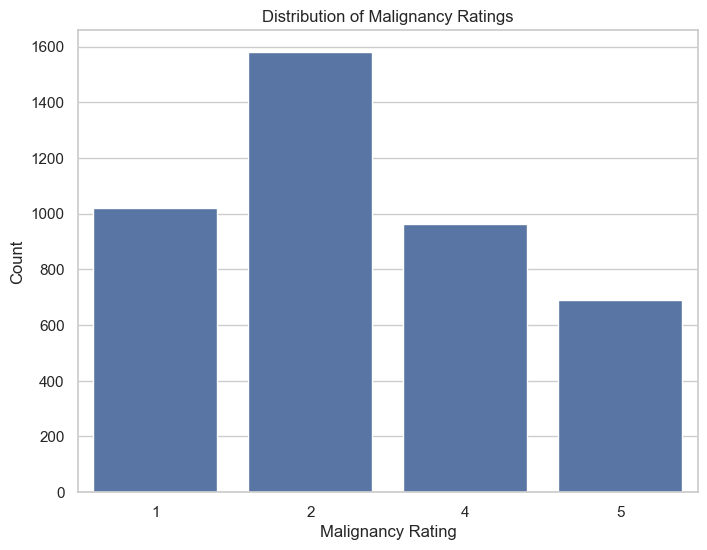

In [7]:
# Set the style of the plots
sns.set(style='whitegrid')

# Create a bar plot for malignancy ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='malignancy', data=df, order=[1, 2, 4, 5])
plt.title('Distribution of Malignancy Ratings')
plt.xlabel('Malignancy Rating')
plt.ylabel('Count')
plt.show()



Diagnosis Category Counts:
diagnosis
benign       2600
malignant    1653
Name: count, dtype: int64


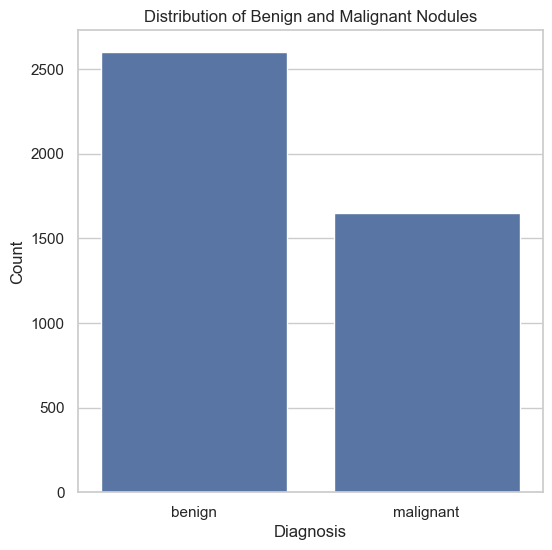

In [8]:
# Define a mapping from malignancy ratings to diagnosis categories
diagnosis_mapping = {1: 'benign', 2: 'benign', 4: 'malignant', 5: 'malignant'}

# Create a new column 'diagnosis' based on the mapping
df['diagnosis'] = df['malignancy'].map(diagnosis_mapping)

# Get the counts of each diagnosis category
diagnosis_counts = df['diagnosis'].value_counts()
print("\nDiagnosis Category Counts:")
print(diagnosis_counts)

# Create a bar plot for diagnosis categories
plt.figure(figsize=(6, 6))
sns.countplot(x='diagnosis', data=df, order=['benign', 'malignant'])
plt.title('Distribution of Benign and Malignant Nodules')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [9]:
# Calculate percentages
total_cases = len(df)
benign_count = diagnosis_counts['benign']
malignant_count = diagnosis_counts['malignant']

benign_percentage = (benign_count / total_cases) * 100
malignant_percentage = (malignant_count / total_cases) * 100

print(f"Percentage of Benign Cases: {benign_percentage:.2f}%")
print(f"Percentage of Malignant Cases: {malignant_percentage:.2f}%")


Percentage of Benign Cases: 61.13%
Percentage of Malignant Cases: 38.87%


We're removing the following columns because they provide basic statistical information about the images and masks, primarily used for diagnostic purposes to assess the quality of the image processing pipeline. These features may be redundant with others in the dataset and are unlikely to directly contribute to malignancy prediction. As such, they function more as diagnostic tools rather than as predictive features.

In [10]:
colums_to_remove = [
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum'
]

df = df.drop(columns=colums_to_remove)

In [11]:
df.head()

,Patient_ID,Nodule_ID,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxisLength,original_shape_MajorAxisLength,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,...,sphericity,margin,lobulation,spiculation,texture,diameter,surface_area,volume,malignancy,diagnosis
0,LIDC-IDRI-0078,Nodule_3,0.219547,0.050905,4.120373,80.942930,99.008535,99.019203,20.891206,99.021336,...,3,5,2,3,5,23.300483,1650.898027,4332.31500,4,malignant
1,LIDC-IDRI-0078,Nodule_5,0.217589,0.044063,4.060242,92.145548,120.001760,132.102385,22.759284,138.959535,...,4,2,4,1,5,32.810517,1994.684094,5230.33875,5,malignant
2,LIDC-IDRI-0078,Nodule_9,0.182946,0.046580,3.388884,72.753701,90.002347,93.020441,14.964124,93.020441,...,4,2,3,1,4,20.891206,1130.172711,2443.74000,4,malignant
3,LIDC-IDRI-0078,Nodule_12,0.233620,0.058188,3.952971,67.935041,84.022631,82.488545,21.459846,93.836693,...,4,2,2,1,5,27.653662,1360.254889,2703.57750,4,malignant
4,LIDC-IDRI-0078,Nodule_24,0.223460,0.047242,3.988505,84.427285,126.006706,114.066691,22.252416,135.031293,...,4,4,4,4,5,28.666400,1876.942178,4554.12750,5,malignant
